In [1]:
#Libraries
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Dropout, Dense, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from imblearn.over_sampling import SMOTE
from tensorflow.keras.callbacks import EarlyStopping

gen_dir = "/Users/w20009829/OneDrive - Northumbria University - Production Azure AD/Term3/"

In [ ]:
#for LSTM, i needs to be 2.12.0 version of tensorflow. upgrade if necessary

# pip install --user --upgrade tensorflow

In [2]:
#loading the data

data_dir = gen_dir + "Data_ALL/EDA/EDA_csv_files2_labeled_segment6_neurokit/" #using baseline6 EDA

#creating output directory if it does not exist
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

data = []
labels = []
for filename in os.listdir(data_dir):
    if filename.endswith(".csv"):
        filepath = os.path.join(data_dir, filename)
        label = int(filename.split("_")[2].split(".")[0])
        signal_df = pd.read_csv(filepath)
        signal_values = signal_df.to_numpy()
        data.append(signal_values)
        labels.append(label)
        
# Convert lists to numpy arrays
data = np.array(data)
labels = np.array(labels)

In [3]:
print(data.shape)
print(labels.shape)

(66, 1439, 1)
(66,)


In [4]:
from imblearn.under_sampling import RandomUnderSampler

# Flatten the data array to a 2D array
data_2d = data.reshape((data.shape[0], -1))

# Print class counts before downsampling
print("Class counts before downsampling:", Counter(labels))

# Random undersampling of the majority class
rus = RandomUnderSampler(random_state=42)
data_resampled, labels_resampled = rus.fit_resample(data_2d, labels)

# Reshape the data array back to the original shape
data_resampled = data_resampled.reshape((data_resampled.shape[0], data.shape[1], data.shape[2]))

# Print class counts after downsampling
print("Class counts after downsampling:", Counter(labels_resampled))

Class counts before downsampling: Counter({0: 47, 1: 19})
Class counts after downsampling: Counter({0: 19, 1: 19})


In [5]:
#just saving it back to data and labels

data = data_resampled
labels = labels_resampled

print(data.shape)
print(labels.shape)

(38, 1439, 1)
(38,)


In [6]:
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=22)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(30, 1439, 1)
(30,)
(8, 1439, 1)
(8,)


In [8]:
# Z-score normalization for baseline_6
from scipy.stats import zscore

# Normalize the data
X_train = np.array([zscore(x, axis=None) for x in X_train])
X_test = np.array([zscore(x, axis=None) for x in X_test])

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(30, 1439, 1)
(30,)
(8, 1439, 1)
(8,)


In [11]:
#basic LSTM

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow as tf
import random

# Set the random seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(123)
random.seed(123)
tf.random.set_seed(123)

filter_size = 32
batch_size = 8
LSTM_unit = 32
neurons = 256

model = Sequential()
model.add(LSTM(LSTM_unit, input_shape=(X_train.shape[1], 1)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(neurons, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(neurons*2, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(neurons*4, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Add early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5)

# Print the model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[early_stop])

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                4352      
                                                                 
 batch_normalization_4 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 256)               8448      
                                                                 
 batch_normalization_5 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 256)              

1/1 [==============================] - 0s 362ms/step
              precision    recall  f1-score   support

           0       0.38      1.00      0.55         3
           1       0.00      0.00      0.00         5

    accuracy                           0.38         8
   macro avg       0.19      0.50      0.27         8
weighted avg       0.14      0.38      0.20         8

Confusion matrix:
 [[3 0]
 [5 0]]
ROC-AUC score: 0.5333333333333334


C:\Anaconda3\envs\xyrus\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\xyrus\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\xyrus\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


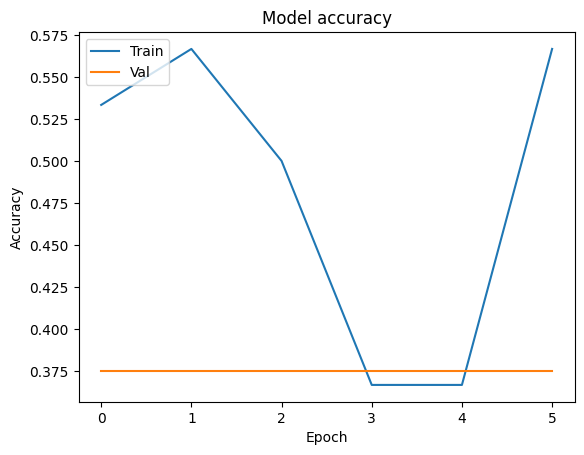

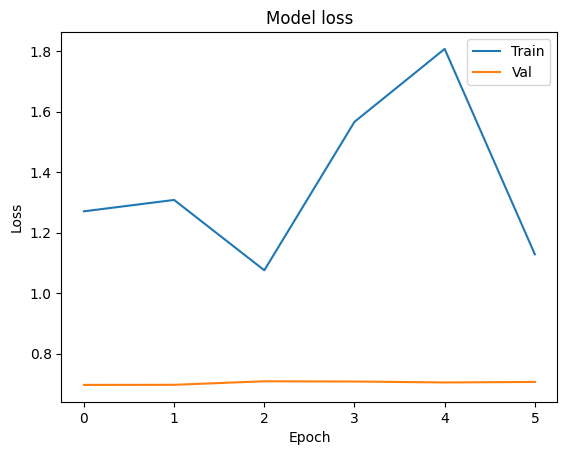

In [12]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict classes for the test set
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

# Print classification report
print(classification_report(y_test, y_pred_classes))

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
print('Confusion matrix:\n', cm)

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print('ROC-AUC score:', roc_auc)

# Plot the training and validation accuracy curves
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot the training and validation loss curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, BatchNormalization, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
import numpy as np
import random
import os
import tensorflow as tf

# Set the random seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(123)
random.seed(123)
tf.random.set_seed(123)

# Define the function to create the model
def create_model(learning_rate=0.001, batch_size=8, LSTM_unit=32, neurons=32, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(LSTM_unit, input_shape=(X_train.shape[1], 1)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(neurons, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(neurons*2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(neurons*4, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    if optimizer == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define the parameter grid for the grid search
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'batch_size': [32],
    'LSTM_unit': [32],
    'optimizer': ['adam', 'rmsprop', 'sgd']
}

# Instantiate the Keras classifier
model = KerasClassifier(build_fn=create_model, epochs=20, verbose=1)

# Instantiate the grid search
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1
)

# Perform the grid search
grid_result = grid_search.fit(X_train, y_train)

# Print the results
print('Best score:', grid_result.best_score_)
print('Best parameters:', grid_result.best_params_)

C:\Anaconda3\envs\xyrus\lib\site-packages\ipykernel_launcher.py:53: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 1.1234 - accuracy: 0.4000
Epoch 2/20
1/1 [==============================] - 0s 229ms/step - loss: 0.7787 - accuracy: 0.5333
Epoch 3/20
1/1 [==============================] - 0s 256ms/step - loss: 0.7737 - accuracy: 0.6000
Epoch 4/20
1/1 [==============================] - 0s 193ms/step - loss: 1.2159 - accuracy: 0.3000
Epoch 5/20
1/1 [==============================] - 0s 267ms/step - loss: 1.1894 - accuracy: 0.4667
Epoch 6/20
1/1 [==============================] - 0s 241ms/step - loss: 0.9724 - accuracy: 0.5000
Epoch 7/20
1/1 [==============================] - 0s 264ms/step - loss: 0.9861 - accuracy: 0.5333
Epoch 8/20
1/1 [==============================] - 0s 243ms/step - loss: 0.7315 - accuracy: 0.5667
Epoch 9/20
1/1 [==============================] - 0s 243ms/step - loss: 0.8604 - accuracy: 0.5667
Epoch 10/20
1/1 [==============================] - 0s 266ms/step - loss: 0.8593 - accuracy: 0.5333
Epoch 11/20
1/1 [=====

cross validation

In [14]:
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Dropout, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

import random

# Set the random seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

filter_size = 64
batch_size = 32
LSTM_unit = 32
num_folds = 10
n_epochs = 20

# Define the optimizer
#optimizer = Adam(learning_rate=0.01)

# Define the CNN model
def create_model():
    model = Sequential()
    model.add(LSTM(LSTM_unit, input_shape=(X_train.shape[1], 1)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(neurons, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(neurons*2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(neurons*4, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Dropout, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

# Set the random seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state = 42)

#K-fold cross-validation lists
score_list = []
precision_list = []
recall_list = []
f1_score_list = []
confusion_matrix_list = []
specificity_list = []
ROC_AUC_list = []


for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train, y_train)):
    #splitting the data into train and validation sets for this fold
    X_train_fold, y_train_fold = X_train[train_idx], y_train[train_idx]
    X_val_fold, y_val_fold = X_train[val_idx], y_train[val_idx]
    
    #defining the early stopping callback
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
    
    #training the model for this fold
    model = create_model()
    history = model.fit(X_train_fold, y_train_fold, epochs=n_epochs, batch_size=batch_size, 
                        validation_data=(X_val_fold, y_val_fold), callbacks=[early_stop], verbose=1)
    
    #predicting the classes for the validation set for this fold
    y_pred = model.predict(X_val_fold)
    y_pred_classes = (y_pred > 0.5).astype(int)
    
    #calculating precision, recall, specificity, F1 score, AUC, and confusion matrix for this fold
    precision_list.append(precision_score(y_val_fold, y_pred_classes))
    recall_list.append(recall_score(y_val_fold, y_pred_classes))
    f1_score_list.append(f1_score(y_val_fold, y_pred_classes))
    #tp, fp, fn, tn = confusion_matrix(y_val_fold, y_pred_classes).ravel()
    tn, fp, fn, tp = confusion_matrix(y_val_fold, y_pred_classes).ravel()
    specificity = tn / (tn + fp)
    specificity_list.append(specificity)
    ROC_AUC_list.append(roc_auc_score(y_val_fold, y_pred))
    confusion_matrix_list.append(confusion_matrix(y_val_fold, y_pred_classes))

    #evaluating the model on the test set for this fold
    #_, test_acc = model.evaluate(X_test, y_test)
    _, test_acc = model.evaluate(X_val_fold, y_val_fold)

    score_list.append(test_acc)
    
    #printing the metrics and confusion matrix for this fold
    print(f'Fold {fold + 1}: Accuracy = {test_acc:.4f}, \
      Precision = {precision_list[-1]:.4f}, \
      Recall = {recall_list[-1]:.4f}, \
      Specificity = {specificity_list[-1]:.4f}, \
      AUC = {ROC_AUC_list[-1]:.4f}, \
      F1 Score = {f1_score_list[-1]:.4f}')
    print(f'Confusion matrix:\n{confusion_matrix_list[-1]}')
    
#Print the average scores for all folds

print(f'Average Accuracy: {np.mean(score_list):.4f} +/- {np.std(score_list):.4f}')
print(f'Average Precision: {np.mean(precision_list):.4f} +/- {np.std(precision_list):.4f}')
print(f'Average Recall/Sensitivity: {np.mean(recall_list):.4f} +/- {np.std(recall_list):.4f}')
print(f'Average Specificity: {np.mean(specificity_list):.4f} +/- {np.std(specificity_list):.4f}')
print(f'Average F1-score: {np.mean(f1_score_list):.4f} +/- {np.std(f1_score_list):.4f}')
print(f'Average ROC_AUC score: {np.mean(ROC_AUC_list):.4f} +/- {np.std(ROC_AUC_list):.4f}')

#printing the overall confusion matrix

overall_cm = np.sum(confusion_matrix_list, axis=0)
print(f'Overall confusion matrix:\n{overall_cm}')

Epoch 1/20
1/1 [==============================] - 4s 4s/step - loss: 1.1919 - accuracy: 0.4074 - val_loss: 0.6990 - val_accuracy: 0.3333
Epoch 2/20
1/1 [==============================] - 0s 295ms/step - loss: 0.9424 - accuracy: 0.5556 - val_loss: 0.7086 - val_accuracy: 0.3333
Epoch 3/20
1/1 [==============================] - 0s 282ms/step - loss: 1.0634 - accuracy: 0.4444 - val_loss: 0.7159 - val_accuracy: 0.3333
Epoch 4/20
1/1 [==============================] - 0s 279ms/step - loss: 0.7159 - accuracy: 0.6667 - val_loss: 0.7158 - val_accuracy: 0.3333
Epoch 4: early stopping
1/1 [==============================] - 0s 56ms/step - loss: 0.6990 - accuracy: 0.3333
Fold 1: Accuracy = 0.3333,       Precision = 0.0000,       Recall = 0.0000,       Specificity = 1.0000,       AUC = 0.0000,       F1 Score = 0.0000
Confusion matrix:
[[1 0]
 [2 0]]


C:\Anaconda3\envs\xyrus\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/20
1/1 [==============================] - 3s 3s/step - loss: 0.9341 - accuracy: 0.4444 - val_loss: 0.6935 - val_accuracy: 0.3333
Epoch 2/20
1/1 [==============================] - 0s 271ms/step - loss: 1.0601 - accuracy: 0.4074 - val_loss: 0.6971 - val_accuracy: 0.3333
Epoch 3/20
1/1 [==============================] - 0s 306ms/step - loss: 0.7594 - accuracy: 0.6296 - val_loss: 0.7019 - val_accuracy: 0.3333
Epoch 4/20
1/1 [==============================] - 0s 318ms/step - loss: 1.1834 - accuracy: 0.3704 - val_loss: 0.7089 - val_accuracy: 0.3333
Epoch 4: early stopping
1/1 [==============================] - 0s 62ms/step - loss: 0.6935 - accuracy: 0.3333
Fold 2: Accuracy = 0.3333,       Precision = 0.0000,       Recall = 0.0000,       Specificity = 1.0000,       AUC = 1.0000,       F1 Score = 0.0000
Confusion matrix:
[[1 0]
 [2 0]]


C:\Anaconda3\envs\xyrus\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/20
1/1 [==============================] - 3s 3s/step - loss: 0.8900 - accuracy: 0.5556 - val_loss: 0.6963 - val_accuracy: 0.3333
Epoch 2/20
1/1 [==============================] - 0s 328ms/step - loss: 1.1741 - accuracy: 0.5556 - val_loss: 0.6994 - val_accuracy: 0.3333
Epoch 3/20
1/1 [==============================] - 0s 311ms/step - loss: 1.0026 - accuracy: 0.5185 - val_loss: 0.7023 - val_accuracy: 0.3333
Epoch 4/20
1/1 [==============================] - 0s 318ms/step - loss: 1.0998 - accuracy: 0.5185 - val_loss: 0.7051 - val_accuracy: 0.3333
Epoch 4: early stopping
1/1 [==============================] - 0s 61ms/step - loss: 0.6963 - accuracy: 0.3333
Fold 3: Accuracy = 0.3333,       Precision = 0.0000,       Recall = 0.0000,       Specificity = 1.0000,       AUC = 1.0000,       F1 Score = 0.0000
Confusion matrix:
[[1 0]
 [2 0]]


C:\Anaconda3\envs\xyrus\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/20
1/1 [==============================] - 3s 3s/step - loss: 1.4450 - accuracy: 0.2593 - val_loss: 0.6966 - val_accuracy: 0.3333
Epoch 2/20
1/1 [==============================] - 0s 318ms/step - loss: 1.3951 - accuracy: 0.4815 - val_loss: 0.7011 - val_accuracy: 0.3333
Epoch 3/20
1/1 [==============================] - 0s 323ms/step - loss: 1.0991 - accuracy: 0.5185 - val_loss: 0.7041 - val_accuracy: 0.3333
Epoch 4/20
1/1 [==============================] - 0s 320ms/step - loss: 1.4798 - accuracy: 0.4074 - val_loss: 0.7075 - val_accuracy: 0.3333
Epoch 4: early stopping
1/1 [==============================] - 0s 60ms/step - loss: 0.6966 - accuracy: 0.3333
Fold 4: Accuracy = 0.3333,       Precision = 0.0000,       Recall = 0.0000,       Specificity = 1.0000,       AUC = 0.0000,       F1 Score = 0.0000
Confusion matrix:
[[1 0]
 [2 0]]


C:\Anaconda3\envs\xyrus\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/20
1/1 [==============================] - 3s 3s/step - loss: 1.0221 - accuracy: 0.5185 - val_loss: 0.6874 - val_accuracy: 0.6667
Epoch 2/20
1/1 [==============================] - 0s 301ms/step - loss: 1.3130 - accuracy: 0.4074 - val_loss: 0.6840 - val_accuracy: 0.6667
Epoch 3/20
1/1 [==============================] - 0s 298ms/step - loss: 1.3590 - accuracy: 0.4815 - val_loss: 0.6838 - val_accuracy: 0.6667
Epoch 4/20
1/1 [==============================] - 0s 283ms/step - loss: 1.1120 - accuracy: 0.4815 - val_loss: 0.6835 - val_accuracy: 0.6667
Epoch 5/20
1/1 [==============================] - 0s 295ms/step - loss: 1.1926 - accuracy: 0.4815 - val_loss: 0.6844 - val_accuracy: 0.6667
Epoch 6/20
1/1 [==============================] - 0s 285ms/step - loss: 1.4408 - accuracy: 0.4074 - val_loss: 0.6854 - val_accuracy: 0.6667
Epoch 7/20
1/1 [==============================] - 0s 339ms/step - loss: 1.0657 - accuracy: 0.4815 - val_loss: 0.6854 - val_accuracy: 0.6667
Epoch 7: early stopping

C:\Anaconda3\envs\xyrus\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/20
1/1 [==============================] - 3s 3s/step - loss: 1.2515 - accuracy: 0.4074 - val_loss: 0.6959 - val_accuracy: 0.3333
Epoch 2/20
1/1 [==============================] - 0s 311ms/step - loss: 1.1616 - accuracy: 0.6667 - val_loss: 0.7017 - val_accuracy: 0.3333
Epoch 3/20
1/1 [==============================] - 0s 308ms/step - loss: 1.0137 - accuracy: 0.6667 - val_loss: 0.7042 - val_accuracy: 0.3333
Epoch 4/20
1/1 [==============================] - 0s 312ms/step - loss: 0.8371 - accuracy: 0.5926 - val_loss: 0.7071 - val_accuracy: 0.3333
Epoch 4: early stopping
1/1 [==============================] - 0s 64ms/step - loss: 0.6959 - accuracy: 0.3333
Fold 6: Accuracy = 0.3333,       Precision = 0.3333,       Recall = 1.0000,       Specificity = 0.0000,       AUC = 0.5000,       F1 Score = 0.5000
Confusion matrix:
[[0 2]
 [0 1]]
Epoch 1/20
1/1 [==============================] - 3s 3s/step - loss: 0.8121 - accuracy: 0.5926 - val_loss: 0.6897 - val_accuracy: 0.6667
Epoch 2/20
1/1 

C:\Anaconda3\envs\xyrus\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/20
1/1 [==============================] - 3s 3s/step - loss: 1.1982 - accuracy: 0.4815 - val_loss: 0.6948 - val_accuracy: 0.3333
Epoch 2/20
1/1 [==============================] - 0s 312ms/step - loss: 1.0428 - accuracy: 0.4444 - val_loss: 0.6954 - val_accuracy: 0.3333
Epoch 3/20
1/1 [==============================] - 0s 304ms/step - loss: 1.3264 - accuracy: 0.3704 - val_loss: 0.6954 - val_accuracy: 0.3333
Epoch 4/20
1/1 [==============================] - 0s 322ms/step - loss: 1.2376 - accuracy: 0.3704 - val_loss: 0.6959 - val_accuracy: 0.3333
Epoch 4: early stopping
1/1 [==============================] - 0s 61ms/step - loss: 0.6948 - accuracy: 0.3333
Fold 8: Accuracy = 0.3333,       Precision = 0.3333,       Recall = 1.0000,       Specificity = 0.0000,       AUC = 0.5000,       F1 Score = 0.5000
Confusion matrix:
[[0 2]
 [0 1]]
Epoch 1/20
1/1 [==============================] - 3s 3s/step - loss: 0.8616 - accuracy: 0.5556 - val_loss: 0.6908 - val_accuracy: 0.6667
Epoch 2/20
1/1 

C:\Anaconda3\envs\xyrus\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/20
1/1 [==============================] - 3s 3s/step - loss: 0.8512 - accuracy: 0.5926 - val_loss: 0.6971 - val_accuracy: 0.6667
Epoch 2/20
1/1 [==============================] - 0s 284ms/step - loss: 1.0594 - accuracy: 0.4074 - val_loss: 0.6957 - val_accuracy: 0.6667
Epoch 3/20
1/1 [==============================] - 0s 287ms/step - loss: 0.8372 - accuracy: 0.4815 - val_loss: 0.6916 - val_accuracy: 0.6667
Epoch 4/20
1/1 [==============================] - 0s 287ms/step - loss: 1.1370 - accuracy: 0.4815 - val_loss: 0.6891 - val_accuracy: 0.6667
Epoch 5/20
1/1 [==============================] - 0s 292ms/step - loss: 0.9307 - accuracy: 0.4074 - val_loss: 0.6867 - val_accuracy: 0.6667
Epoch 6/20
1/1 [==============================] - 0s 291ms/step - loss: 0.7606 - accuracy: 0.5926 - val_loss: 0.6839 - val_accuracy: 0.6667
Epoch 7/20
1/1 [==============================] - 0s 292ms/step - loss: 1.0935 - accuracy: 0.7407 - val_loss: 0.6801 - val_accuracy: 0.6667
Epoch 8/20
1/1 [=======

C:\Anaconda3\envs\xyrus\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
